Create a SLP project using labeled frames from from Label3D - com_net model
----------------------------------------------------
**This notebook takes labeled training data from Label3D and packages it into a SLP project to train the com_net model on the coarse bird location (head, body, tail).**

Reformat 3D points from Label3D into an array of 2D points    
- takes in a matfile from Label3D
- reshapes to (n_frames, n_nodes, 3)
- averages across the labeled points for each coarse region:
    - head: left eye, right eye (7, 11)
    - body: center back, base tail, left wing, right wing (4, 5, 8, 12)
    - tail: tip tail (6)
- reprojects onto each camera view to get an array of shape (n_frames, n_cams, n_nodes, 2) 
- downsamples the video frames to make them easier to work with
    
Then, pass through `create_slp_project()` to make the SLP project file.

The coarse predictions are then used to crop around the bird (posture net) and the head (face net) to predict the detaied keypoints and seed presence, respectively, on cropped video frames.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import cv2
import mat73

import os 
import sys
sys.path.append("../utils/")
sys.path.append("../camera_calibration/")
import pySBA

# from comCreateDataset import projectData, resize_and_pad_rows

In [2]:
''' set paths '''
proj_date = input("input today's date (YYMMDD): ")

# skeleton file (nodes, edges, symmetry)
skeleton_file = './/com_skeleton_IL.csv'

# to save SLP project
slp_project_dir = '..//training_files/SLP/'
slp_project_file = f'{proj_date}_com_net.slp'
slp_project_path = f'{slp_project_dir}{slp_project_file}'

# to save training images as video
training_vid_dir = '..//training_files/com_vids/'
vid_file = f'{proj_date}_com_vid.avi'
training_vid_path = f'{training_vid_dir}{vid_file}'

# Label3D training data
training_dir = '..//training_files/Label3D/'
training_files = []
for f in os.listdir(training_dir):
    if 'videos' in f:
        training_files.append(f)

input today's date (YYMMDD): 240905


In [3]:
''' Functions '''
def avgBodyParts(data3D, nParts=18):
    headInd = [7, 11]
    bodyInd = [4, 5, 8, 12]
    tailInd = [6]
    nFrames = data3D.shape[0]
    nParts = data3D.shape[1]//3
    data3D = np.reshape(data3D, (nFrames, nParts, 3))
    headPts = np.mean(data3D[:, headInd], axis=1)
    bodyPts = np.mean(data3D[:, bodyInd], axis=1)
    tailPts = np.mean(data3D[:, tailInd], axis=1)
    return (headPts, bodyPts, tailPts)

def projectData(matfile):
    camParams = pySBA.convertParams(matfile['camParams'])
    pt3d = avgBodyParts(matfile['data_3D'])
    sba = pySBA.PySBA(camParams, np.NaN, np.NaN, np.NaN, np.NaN) #points_2d[:, :2], camera_ind, point_2dind3d, points_2d[:, 2])
    nFrames = pt3d[0].shape[0]
    nParts = len(pt3d)
    nCams = camParams.shape[0]
    allLabels = np.full((nFrames, nCams, nParts, 2), np.NaN)
    for nCam in range(nCams):
        for nPart in range(nParts):
            allLabels[:, nCam, nPart, :] = sba.project(pt3d[nPart], np.tile(camParams[nCam],(nFrames,1)))

    return allLabels

def resize_and_pad_rows(img, ds_size):
    # Crops input image to a fixed size, by appending rows at bottom of image as necessary to maintain aspect ratio
    imShape = img.shape
    if imShape[1] / imShape[0] == ds_size[0] / ds_size[1]: # if aspect ratio is the same
        ds_img = cv2.resize(img, ds_size, interpolation=cv2.INTER_AREA)
    else: # pad rows to preserve aspect ratio
        ds_fac = imShape[1] / ds_size[0]
        ds_row = int(np.round(imShape[0] / ds_fac))
        ds_img = cv2.resize(img, (ds_size[0], ds_row), interpolation=cv2.INTER_AREA)
        fill_row = np.full((ds_size[1]-ds_row, ds_size[0]), 0, dtype='uint8')
        ds_img = np.concatenate((ds_img,fill_row), axis=0)
    return ds_img

In [4]:
''' Get coarse 3D points and reformat into an array of 2D points '''
# get the 2D points and frames for each Label3D file
all_labels = [] # (n_frames, n_cams, n_nodes, 2)
all_images = [] # CHECK SHAPE
for fn in training_files:
    print(fn)
    file_path = f"{training_dir}{fn}"
    matfile = mat73.loadmat(file_path)
    labels = projectData(matfile)
    images = []
    for data in matfile['videos']:
        images.append(data[0])
    all_labels.append(labels)
    all_images.append(images)
    
# reformat
all_labels = np.concatenate(all_labels, axis=0)
n_cams = all_labels.shape[1]
all_cams = [] # list (len (n_cams,)) of arrays (w, h, n_frames)
for c in range(n_cams):
    these_images = np.concatenate([i[c] for i in all_images], axis=2)
    all_cams.append(np.squeeze(these_images))
del all_images

20240904_125517_Label3D_videos.mat


In [5]:
ds_fac = 4 # downsampling factor
im_w = all_cams[0].shape[0]
im_h = all_cams[0].shape[1]
ds_size = (im_w//ds_fac, im_h//ds_fac) # pixels

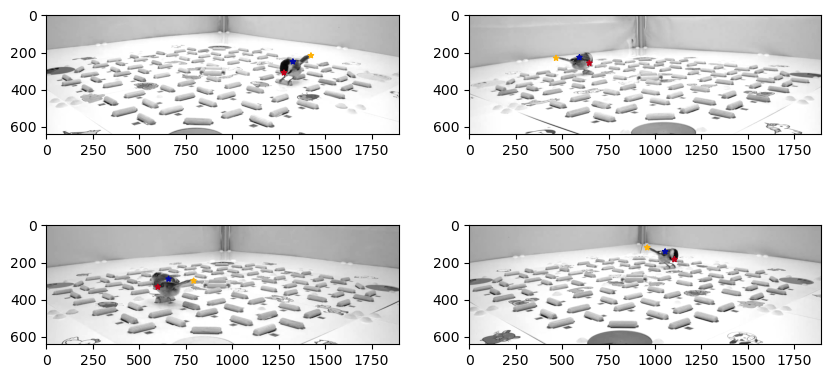

<Figure size 640x480 with 0 Axes>

In [7]:
# plot a frame to check output
ex_frame = 0

# fig params
f, ax = plt.subplots(n_cams//2, 2, figsize=(10, 5))
colors = ['xkcd:scarlet', 'xkcd:cobalt blue', 'xkcd:saffron']

# plot for each camera
for n_cam in range(n_cams):
    # get subplot index
    if n_cam < n_cams//2:
        r = n_cam
        c = 0
    else:
        r = n_cam - n_cams//2
        c = 1
    
    # label keypoints
    ax[r, c].imshow(images[n_cam][:, :, :, ex_frame], cmap='gray')
    ax[r, c].scatter(labels[ex_frame, n_cam, :, 0], 
                     labels[ex_frame, n_cam, :, 1],
                     c=colors, marker='*', s=15)

plt.show()
plt.tight_layout()

In [20]:
''' concatenate across camera views to pass into SLP '''
label_data = [] # shape (total_frames, n_nodes, 2)
image_data = [] # shape (total_frames, ds_w, ds_h)

for n_cam in range(n_cams):
    images = np.transpose(all_cams[n_cam], axes=[2, 0, 1]) 
    labels = all_labels[:, n_cam]
    n_frames = labels.shape[0]
    for f in range(n_frames):
        if np.isfinite(labels[f].sum()): # all points are labeled
            ds_ann = labels[f] / ds_fac
            ds_im = cv2.resize(images[f], ds_size, interpolation=cv2.INTER_AREA)
            label_data.append(ds_ann)
            image_data.append(ds_im.T)
label_data = np.asarray(label_data)
image_data = np.asarray(image_data)

In [24]:
ds_im.T.shape

(160, 474)

In [12]:
''' save the training images as a downsampled movie '''
n_frames, ds_w, ds_h = image_data.shape
fourcc = cv2.VideoWriter_fourcc(*'H264')
video = cv2.VideoWriter(training_vid_path,
                        fourcc=fourcc,
                        fps=50,
                        frameSize=(ds_w, ds_h),
                        isColor=False
                       )
for img in image_data:
    video.write(img)
video.release()
cv2.destroyAllWindows()

In [45]:
create_slp_project(images=image_data, 
                   skeleton_file=skeleton_file,
                   keypoints=label_data,
                   slp_labels_file=slp_labels_file)

NameError: name 'create_slp_project' is not defined